In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
import requests
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from scipy import stats
from sklearn.ensemble import RandomForestClassifier 

### Get data

In [113]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))

### fit normal distribution

In [4]:
from scipy.stats import norm

In [88]:
# Fit a normal distribution to the data:
mu, std = norm.fit(data.HippoNV)
from scipy import stats

In [89]:
mu, std = norm.fit(data.HippoNV)
sde = stats.sem(data.HippoNV)

In [90]:
lower_bound = mu - 1.96 * sde
upper_bound = mu + 1.96 * sde
lower_bound, upper_bound

(0.46506596496644076, 0.4782598164919732)

### Bootstrap

In [92]:
import random
num_samples = 1000
mean_v = []
for i in range(num_samples):
    this_sample = np.random.choice(list(data.HippoNV.values), len(data.HippoNV), replace=True)
    mu, std = norm.fit(this_sample)
    mean_v.append(mu)
    
print("Lower bound: {lower}".format(lower = np.percentile(mean_v, 2.5) ) )
print("Upper bound: {upper}".format(upper = np.percentile(mean_v, 97.5) ) )

Lower bound: 0.46498151520976794
Upper bound: 0.47841990061334627


In [94]:
data.head(3)

,DX_bl,AGE,PTGENDER,PTEDUCAT,FDG,AV45,HippoNV,e2_1,e4_1,rs3818361,rs744373,rs11136000,rs610932,rs3851179,rs3764650,rs3865444,MMSCORE,TOTAL13,ID
0,0,71.7,2,14,6.82111,1.105695,0.529299,1,0,1,1,1,1,1,0,0,26,8.00,1
1,0,77.7,1,18,6.36744,1.105695,0.537761,0,0,1,0,1,1,0,0,1,30,1.67,2
2,0,72.8,2,18,6.36744,1.105695,0.268882,0,1,1,1,1,0,1,0,1,30,12.00,3


In [129]:
data.groupby('DX_bl').count()

,AGE,PTGENDER,PTEDUCAT,FDG,AV45,HippoNV,e2_1,e4_1,rs3818361,rs744373,rs11136000,rs610932,rs3851179,rs3764650,rs3865444,MMSCORE,TOTAL13,ID
DX_bl,,,,,,,,,,,,,,,,,,
0,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285
1,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232


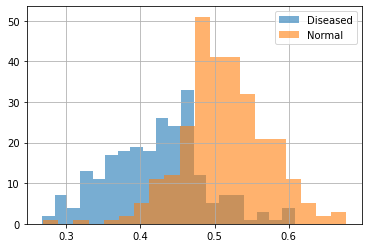

In [128]:
# data.loc[data.DX_bl == 0].HippoNV.hist(bins=10)
data.loc[data.DX_bl == 1].HippoNV.hist(bins=20,alpha=0.6)
data.loc[data.DX_bl == 0].HippoNV.hist(bins=20,alpha=0.6)
plt.legend(["Diseased","Normal"])

In [133]:
num_samples = 10000
bs0_mean_v = []
bs1_mean_v = []
class0_values = data.loc[data.DX_bl==0].HippoNV
class1_values = data.loc[data.DX_bl==1].HippoNV
for i in range(num_samples):
    this_sample = np.random.choice(class0_values, len(class0_values), replace=True)
    mu, std = norm.fit(this_sample)
    bs0_mean_v.append(mu)
    
    this_sample = np.random.choice(class1_values, len(class1_values), replace=True)
    mu, std = norm.fit(this_sample)
    bs1_mean_v.append(mu)

bs_meanDiff = np.array(bs0_mean_v) - np.array(bs1_mean_v)
print("Lower bound: {lower}".format(lower = np.percentile(bs_meanDiff, 2.5) ) )
print("Upper bound: {upper}".format(upper = np.percentile(bs_meanDiff, 97.5) ) )

Lower bound: 0.0806491605050196
Upper bound: 0.10226212754520275


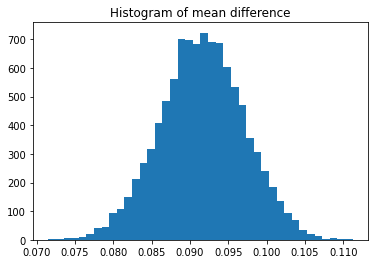

In [156]:
plt.hist(bs_meanDiff, bins=40)
plt.title('Histogram of mean difference')
plt.show()

In [139]:
regr = linear_model.LinearRegression()
lm = regr.fit(data[['AGE','PTGENDER','PTEDUCAT']], data[['MMSCORE']])

In [160]:
import statsmodels.api as sm
model = sm.OLS(data[['MMSCORE']], sm.add_constant(data[['AGE','PTGENDER','PTEDUCAT']]) )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                MMSCORE   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     11.15
Date:                Sat, 16 May 2020   Prob (F-statistic):           4.24e-07
Time:                        22:58:05   Log-Likelihood:                -1105.7
No. Observations:                 517   AIC:                             2219.
Df Residuals:                     513   BIC:                             2236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.7038      1.111     24.929      0.0

In [161]:
coef_pd = pd.DataFrame()
for i in range(1000):
    this_sample = data.sample(len(data),replace=True)
    model = sm.OLS(this_sample[['MMSCORE']], sm.add_constant(this_sample[['AGE','PTGENDER','PTEDUCAT']]) )
    results = model.fit()
    coef_pd = coef_pd.append(results.params,ignore_index=True)

In [162]:
print("Lower bound: {lower}".format(lower = np.percentile(coef_pd.AGE, 2.5) ) )
print("Upper bound: {upper}".format(upper = np.percentile(coef_pd.AGE, 97.5) ) )

Lower bound: -0.052708133939386795
Upper bound: 0.005711161072693149


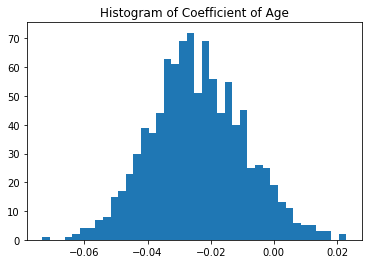

In [163]:
plt.hist(coef_pd.AGE, bins=40)
plt.title('Histogram of Coefficient of Age')
plt.show()

Lower bound: 0.1027649489858022
Upper bound: 0.2443780551212005


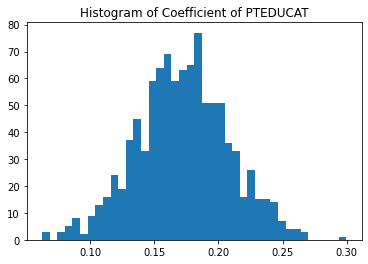

In [166]:
print("Lower bound: {lower}".format(lower = np.percentile(coef_pd.PTEDUCAT, 2.5) ) )
print("Upper bound: {upper}".format(upper = np.percentile(coef_pd.PTEDUCAT, 97.5) ) )
plt.hist(coef_pd.PTEDUCAT, bins=40)
plt.title('Histogram of Coefficient of PTEDUCAT')
plt.show()

#### Tree models

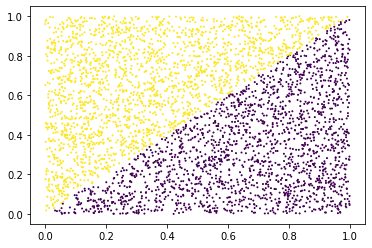

In [195]:
# Generate data
data = pd.DataFrame( np.random.uniform(0, 1, size=[4000, 2]),
                    columns=['X1','X2'])
data['X12'] = 0.5 * (data.X1 - data.X2)
data['label'] = 1
data.loc[data.X12>0,'label'] = 0

plt.scatter(data.X1, data.X2, s=1, marker='o', c = data.label)

In [209]:
# set training and testing data
x_train, x_test, y_train, y_test = train_test_split(
            data[['X1','X2']], data['label'], test_size=0.95)


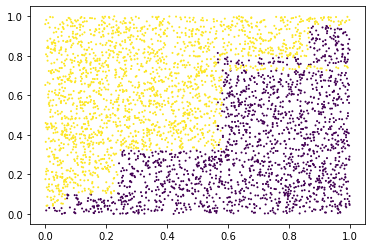

Confusion matrix:
[[1665  180]
 [ 106 1849]]


Text(0.5, 1.0, 'ROC Curve')

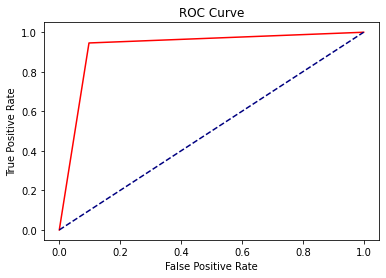

In [221]:
from sklearn import tree # import DecisionTreeClassifier
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
x_test['pred_tree'] = clf.predict(x_test[['X1','X2']])
plt.scatter(x_test.X1, x_test.X2, s=1, marker='o', c = x_test.pred_tree)
plt.show()

from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, x_test['pred_tree']))

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred_prob = clf.predict_proba(x_test[['X1','X2']])
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])
plt.plot(fpr, tpr, color = 'red', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # random prediction
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [263]:
#### Real data

Confusion matrix:
[[1764   81]
 [  67 1888]]


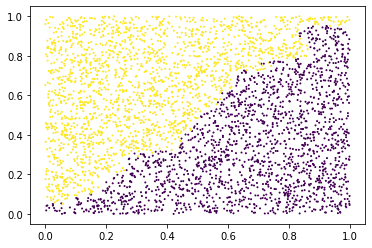

In [222]:
forest = RandomForestClassifier(n_estimators = 200, oob_score = True)
forest.fit(x_train, y_train)

x_test['pred_rf'] = forest.predict(x_test[['X1','X2']])
plt.scatter(x_test.X1, x_test.X2, s=1, marker='o', c = x_test.pred_rf)

print("Confusion matrix:")
print(confusion_matrix(y_test, x_test['pred_rf']))

In [223]:
pred_prob = forest.predict_proba(x_test[['X1','X2']])

Text(0.5, 1.0, 'ROC Curve')

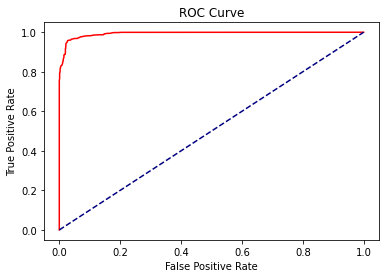

In [224]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])
plt.plot(fpr, tpr, color = 'red', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # random prediction
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [325]:
#### Real data
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
X = data.iloc[:, 1:16]
Y = data['DX_bl']

In [298]:
pred_rf = forest.predict(x_test)
#pd.Series(pred_rf)
# pd.Series(pred_rf) != y_test
#y_test
#pred_rf = pd.DataFrame({'label':pred_rf})
sum(sum(pred_rf == y_test.values))/len(y_test)
# pred_rf == y_test.values

129.45173745173744

In [333]:
tree_num_v = [1, 5, 10, 20, 30, 40, 50, 100]
error_df = pd.DataFrame()
for itree in tree_num_v:
    error_this_tree_num = []
    for irep in range(100):
        x_train, x_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.5)
        forest = RandomForestClassifier(n_estimators = itree)
        forest.fit(x_train, y_train)
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(pred_rf)
        this_err = pd.DataFrame({'num_trees':[itree],
                                 'replicate':[irep],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)

Text(0.5, 1.0, 'Error vs. number of trees')

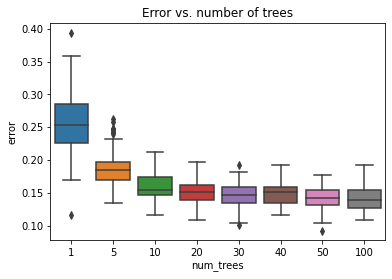

In [334]:
import seaborn as sns
ax = sns.boxplot(x="num_trees", y="error", data=error_df)
ax.set_title("Error vs. number of trees")

In [353]:
fea_num_v = range(1,x_train.shape[1]+1)
error_df = pd.DataFrame()
for ifeature in fea_num_v:
    for irep in range(100):
        x_train, x_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.5)
        forest = RandomForestClassifier(max_features=ifeature)
        forest.fit(x_train, y_train)
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(pred_rf)
        this_err = pd.DataFrame({'num_features':[ifeature],
                                 'replicate':[irep],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)

Text(0.5, 1.0, 'Error vs. number of features')

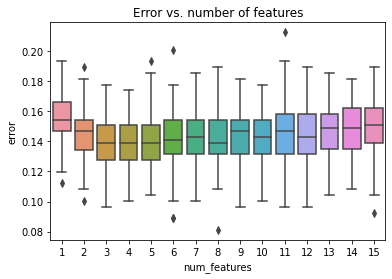

In [354]:
ax = sns.boxplot(x="num_features", y="error", data=error_df)
ax.set_title("Error vs. number of features")

In [351]:
node_num_v = [2,3,4,5,10,30,50,100]
error_df = pd.DataFrame()
for inode in node_num_v:
    for irep in range(100):
        x_train, x_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.5)
        forest = RandomForestClassifier(max_leaf_nodes=inode)
        forest.fit(x_train, y_train)
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(pred_rf)
        this_err = pd.DataFrame({'num_nodes':[inode],
                                 'replicate':[irep],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)

Text(0.5, 1.0, 'Error vs. number of nodes')

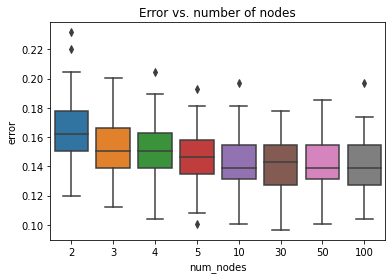

In [352]:
ax = sns.boxplot(x="num_nodes", y="error", data=error_df)
ax.set_title("Error vs. number of nodes")

#### Entropy and Gini index

In [365]:
def entropy(p_v):
    e = 0
    for p in p_v:
        e = e + (0 if p ==0 else -p * np.log2(p) )
    return e

def gini(p_v):
    e = 0
    for p in p_v:
        e = e + (0 if p ==0 else p * (1-p) )
    return e    

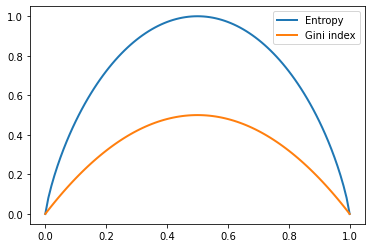

In [379]:
entropy_v = []
gini_v = []
for i in np.arange(0.0, 1.01, 0.01):
    entropy_v.append( entropy([i,1-i]) )
    gini_v.append( gini([i,1-i]) )
plt. plot(np.arange(0.0, 1.01, 0.01), 
          entropy_v, linewidth=2.0)
plt. plot(np.arange(0.0, 1.01, 0.01), 
          gini_v, linewidth=2.0)
plt.legend(["Entropy","Gini index"])

In [383]:
#### random forest vs. decision tree
from sklearn import tree 
error_df = pd.DataFrame()
for inode in node_num_v:
    for irep in range(100):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)
        forest = RandomForestClassifier(max_leaf_nodes=inode)
        forest.fit(x_train, y_train)
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(pred_rf)
        this_err = pd.DataFrame({'model':['randomforest'],
                                 'replicate':[irep],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)
        
        
        decision_tree = tree.DecisionTreeClassifier(max_depth=3)
        decision_tree.fit(x_train, y_train)
        pred_tree = decision_tree.predict(x_test)
        
        this_error = sum(pred_tree != y_test)/len(pred_tree)
        this_err = pd.DataFrame({'model':['tree'],
                                 'replicate':[irep],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)

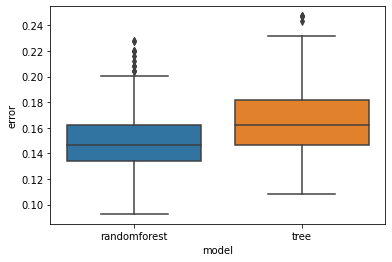

In [384]:
ax = sns.boxplot(x="model", y="error", data=error_df)
# ax.set_title("Error vs. number of nodes")